# Q Function
* used to approximate the reward based on a state
* Q(s,a) calculates the expected future value from state **s** and action **a**
* in DQN, we use a **neural network to approximate the reward**

# Classes
* Environment
* Agent
* Runner

## Environment

In [1]:
class Action:
    def __init__(self, act, days, percentage):
        self.act = act
        self.days = days
        self.percentage = percentage

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime

BUY = 'buy'
SELL = 'sell'
SKIP = 'skip'

class Environment:
    
    min_days_to_hold = 5
    max_days_to_hold = 15
    max_drawdowns = 3
    
    def __init__(self, 
                 ticker, 
                 initial_deposit = 100000,
                 from_date = datetime.datetime(2007, 1, 1), 
                 to_date = datetime.datetime(2017, 1, 1),
                 window = 50):
        self.initial_deposit = initial_deposit
        self.window = window
        self.data = pdr.get_data_google(ticker, from_date, to_date)
        self.pct_data = self.data.pct_change().fillna(0)
        self.data_length = len(self.data)
        
        actions = np.array([BUY, SELL, SKIP])
        days_to_holds = np.arange(Environment.min_days_to_hold, 
                                  Environment.max_days_to_hold + 1,
                                  2)
        
        self.action_space = [Action(act, days, 3) for act in actions for days in days_to_holds]
        self.reset()
        
    def reset(self):
        self.deposit = self.initial_deposit
        self.current_index = self.window
        self.actions = {}
        self.drawdowns = 0
        
        return self.state()
    
    def score(self):
        return self.deposit
    
    def enough_data_provided(self):
        return self.current_index + Environment.max_days_to_hold <= self.data_length
    
    def state(self):
        return self.pct_data.iloc[self.current_index - self.window:self.current_index]['Close']
    
    # def price_state(self):
    #    return self.data.iloc[self.current_index - self.window:self.current_index]['Close']
        
    def state_size(self):
        return self.window
    
    def action_size(self):
        return len(self.action_space)
        
    def step(self, action_idx: int):
        action = self.action_space[action_idx]
        #print('\t=> current action is: {} at {}'.format(action, self.data.index[self.current_index]))
        
        df = self.data.iloc[self.current_index: self.current_index + action.days]
        on_date = df.index[0]
        first_day_price = df.iloc[0]['Close']
        last_day_price = df.iloc[-1]['Close']
        
        if action.act == BUY:
            reward = last_day_price - first_day_price
        elif action.act == SELL:
            reward = first_day_price - last_day_price
        elif action.act == SKIP:
            reward = 0
            
        self.actions[on_date] = (action, reward)
        
        self.current_index += action.days
        self.deposit += reward * (self.deposit*action.percentage/100)
        
        if reward < 0:
            self.drawdowns += 1
        else:
            self.drawdowns = 0
        
        next_state = self.state()
        done = self.drawdowns > Environment.max_drawdowns
        _ = None
        return next_state, reward, done, _ 

## Agent

In [3]:
import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import mean_squared_error

class Agent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.999
        self.learning_rate = 0.001
        self.model = self._build_model()
    
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(48, input_dim=self.state_size, activation='relu'))
        model.add(Dense(36, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=mean_squared_error,
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

Using TensorFlow backend.


## Runner

In [4]:
env = Environment('AAPL')
state_size = env.state_size()
action_size = env.action_size()
print('Action size: {}, state size: {}'.format(action_size, state_size))

Action size: 18, state size: 50


In [5]:
agent = Agent(state_size, action_size)
EPISODES = 50
batch_size = 32

In [6]:
max_reward = None
for e in range(EPISODES):
    print('==> EPISODE {}'.format(e))
    state = env.reset()
    state = state.values.reshape([1, state_size])
    while env.enough_data_provided():
        action_idx = agent.act(state)
        next_state, reward, done, _ = env.step(action_idx) # build these parameters into the NN model
        # reward = reward if not done else -10
        next_state = next_state.values.reshape([1, state_size])
        agent.remember(state, action_idx, reward, next_state, done)
        state = next_state
        
        if done:
            break
        elif len(agent.memory) > batch_size:
            agent.replay(batch_size)
            print("episode: {}/{}, score: {}, e: {:.2}".format(e, EPISODES, env.score(), agent.epsilon))
    
    if max_reward is None or max_reward[0] < env.score():
        max_reward = (env.score(), env.actions)

==> EPISODE 0
episode: 0/50, score: 125282.71972108448, e: 1.0
==> EPISODE 1
episode: 1/50, score: 101860.0, e: 1.0
episode: 1/50, score: 100423.774, e: 1.0
episode: 1/50, score: 100604.53679320001, e: 1.0
episode: 1/50, score: 100604.53679320001, e: 1.0
episode: 1/50, score: 96499.87169203744, e: 0.99
episode: 1/50, score: 96499.87169203744, e: 0.99
episode: 1/50, score: 99655.41749636707, e: 0.99
episode: 1/50, score: 97383.27397744989, e: 0.99
episode: 1/50, score: 97383.27397744989, e: 0.99
episode: 1/50, score: 90605.39810861938, e: 0.99
episode: 1/50, score: 88757.04798720355, e: 0.99
episode: 1/50, score: 93683.06415049334, e: 0.99
episode: 1/50, score: 99304.04799952294, e: 0.99
episode: 1/50, score: 99304.04799952294, e: 0.99
episode: 1/50, score: 95907.84955793925, e: 0.98
episode: 1/50, score: 95907.84955793925, e: 0.98
episode: 1/50, score: 95274.85775085684, e: 0.98
episode: 1/50, score: 101934.57030764173, e: 0.98
episode: 1/50, score: 93922.51308146109, e: 0.98
episode: 

episode: 2/50, score: 101552.47814377121, e: 0.85
episode: 2/50, score: 101552.47814377121, e: 0.84
episode: 2/50, score: 100760.3688142498, e: 0.84
episode: 2/50, score: 96286.6084388971, e: 0.84
episode: 2/50, score: 96286.6084388971, e: 0.84
episode: 2/50, score: 96286.6084388971, e: 0.84
episode: 2/50, score: 91664.85123383004, e: 0.84
episode: 2/50, score: 98952.20690691953, e: 0.84
episode: 2/50, score: 98952.20690691953, e: 0.84
episode: 2/50, score: 109015.64634935325, e: 0.84
episode: 2/50, score: 109015.64634935325, e: 0.84
episode: 2/50, score: 112416.93451545307, e: 0.84
episode: 2/50, score: 108943.25123892559, e: 0.84
episode: 2/50, score: 113943.74647079228, e: 0.83
episode: 2/50, score: 117362.05886491605, e: 0.83
episode: 2/50, score: 117362.05886491605, e: 0.83
episode: 2/50, score: 98631.07427007545, e: 0.83
episode: 2/50, score: 87653.43570381605, e: 0.83
episode: 2/50, score: 87653.43570381605, e: 0.83
episode: 2/50, score: 87653.43570381605, e: 0.83
episode: 2/50,

episode: 3/50, score: 69509.32537994334, e: 0.71
episode: 3/50, score: 70364.29008211664, e: 0.71
episode: 3/50, score: 73235.153117467, e: 0.71
episode: 3/50, score: 73235.153117467, e: 0.71
episode: 3/50, score: 74004.1222252004, e: 0.71
episode: 3/50, score: 73848.71356852747, e: 0.71
episode: 3/50, score: 74025.95048109193, e: 0.71
episode: 3/50, score: 78778.41650197803, e: 0.71
episode: 3/50, score: 78022.14370355905, e: 0.71
episode: 3/50, score: 79684.01536444486, e: 0.71
episode: 3/50, score: 79660.11015983553, e: 0.71
episode: 3/50, score: 79660.11015983553, e: 0.71
episode: 3/50, score: 80544.33738260971, e: 0.71
episode: 3/50, score: 85207.8545170628, e: 0.71
episode: 3/50, score: 86460.40997846363, e: 0.7
episode: 3/50, score: 86616.03871642487, e: 0.7
episode: 3/50, score: 87343.61344164284, e: 0.7
episode: 3/50, score: 87343.61344164284, e: 0.7
episode: 3/50, score: 84146.83718967871, e: 0.7
episode: 3/50, score: 84146.83718967871, e: 0.7
episode: 3/50, score: 84146.8371

episode: 4/50, score: 71362.58796674083, e: 0.6
episode: 4/50, score: 76843.23472258652, e: 0.6
episode: 4/50, score: 78641.36641509505, e: 0.6
episode: 4/50, score: 84822.57781532154, e: 0.6
episode: 4/50, score: 94670.47909968036, e: 0.6
episode: 4/50, score: 91148.73727717227, e: 0.6
episode: 4/50, score: 93582.40856247277, e: 0.6
episode: 4/50, score: 89932.69462853632, e: 0.6
episode: 4/50, score: 89932.69462853632, e: 0.6
episode: 4/50, score: 92333.89757511824, e: 0.6
episode: 4/50, score: 92333.89757511824, e: 0.6
episode: 4/50, score: 89037.57743168651, e: 0.6
episode: 4/50, score: 90773.8101916044, e: 0.6
episode: 4/50, score: 98780.0602505039, e: 0.6
episode: 4/50, score: 99698.7148108336, e: 0.59
episode: 4/50, score: 99459.4378952876, e: 0.59
episode: 4/50, score: 99459.4378952876, e: 0.59
episode: 4/50, score: 99459.4378952876, e: 0.59
episode: 4/50, score: 99459.4378952876, e: 0.59
episode: 4/50, score: 95073.27668410543, e: 0.59
episode: 4/50, score: 97953.99696763381, 

episode: 4/50, score: 128573.23237209296, e: 0.51
episode: 4/50, score: 128573.23237209296, e: 0.51
episode: 4/50, score: 153220.72101782318, e: 0.51
==> EPISODE 5
episode: 5/50, score: 100000.0, e: 0.51
episode: 5/50, score: 100000.0, e: 0.51
episode: 5/50, score: 101200.0, e: 0.51
episode: 5/50, score: 105541.48, e: 0.51
episode: 5/50, score: 99778.915192, e: 0.51
episode: 5/50, score: 99778.915192, e: 0.51
episode: 5/50, score: 98162.49676588959, e: 0.51
episode: 5/50, score: 96690.05931440125, e: 0.51
episode: 5/50, score: 96545.02422542965, e: 0.5
episode: 5/50, score: 96545.02422542965, e: 0.5
episode: 5/50, score: 88493.16920502881, e: 0.5
episode: 5/50, score: 83953.46962481084, e: 0.5
episode: 5/50, score: 84180.14399279782, e: 0.5
episode: 5/50, score: 86680.29426938391, e: 0.5
episode: 5/50, score: 84755.99173660358, e: 0.5
episode: 5/50, score: 84755.99173660358, e: 0.5
episode: 5/50, score: 84755.99173660358, e: 0.5
episode: 5/50, score: 76085.45378194904, e: 0.5
episode: 

episode: 6/50, score: 156251.25534317165, e: 0.43
episode: 6/50, score: 156251.25534317165, e: 0.43
episode: 6/50, score: 155266.87243450966, e: 0.43
episode: 6/50, score: 162533.3620644447, e: 0.43
episode: 6/50, score: 171700.24368487936, e: 0.43
episode: 6/50, score: 180508.46618591362, e: 0.43
episode: 6/50, score: 194858.88924769376, e: 0.43
episode: 6/50, score: 189130.03790381155, e: 0.43
episode: 6/50, score: 189130.03790381155, e: 0.43
episode: 6/50, score: 179938.31806168632, e: 0.43
episode: 6/50, score: 181233.87395173046, e: 0.43
episode: 6/50, score: 181233.87395173046, e: 0.43
episode: 6/50, score: 181233.87395173046, e: 0.43
episode: 6/50, score: 181233.87395173046, e: 0.43
episode: 6/50, score: 187921.40390054934, e: 0.43
episode: 6/50, score: 187921.40390054934, e: 0.43
episode: 6/50, score: 187921.40390054934, e: 0.42
episode: 6/50, score: 187921.40390054934, e: 0.42
episode: 6/50, score: 172981.65229045568, e: 0.42
episode: 6/50, score: 172981.65229045568, e: 0.42
e

episode: 9/50, score: 144819.42785199409, e: 0.36
episode: 9/50, score: 144819.42785199409, e: 0.36
episode: 9/50, score: 143429.16134461493, e: 0.36
episode: 9/50, score: 144763.05254511983, e: 0.36
episode: 9/50, score: 136728.7031288657, e: 0.36
episode: 9/50, score: 136728.7031288657, e: 0.36
episode: 9/50, score: 143004.55060248062, e: 0.36
episode: 9/50, score: 136483.54309500748, e: 0.36
episode: 9/50, score: 136483.54309500748, e: 0.36
episode: 9/50, score: 112080.28558962014, e: 0.36
episode: 9/50, score: 113189.88041695737, e: 0.36
episode: 9/50, score: 116313.9211164654, e: 0.36
episode: 9/50, score: 107032.07021137147, e: 0.36
episode: 9/50, score: 111077.88246536131, e: 0.36
episode: 9/50, score: 114710.12922197863, e: 0.36
episode: 9/50, score: 114710.12922197863, e: 0.36
episode: 9/50, score: 114710.12922197863, e: 0.36
episode: 9/50, score: 118048.1939823382, e: 0.36
episode: 9/50, score: 118048.1939823382, e: 0.36
episode: 9/50, score: 113975.53128994752, e: 0.36
episo

episode: 10/50, score: 122454.65685235702, e: 0.31
episode: 10/50, score: 122748.54802880267, e: 0.31
episode: 10/50, score: 125804.98687471985, e: 0.31
episode: 10/50, score: 125804.98687471985, e: 0.31
episode: 10/50, score: 131617.1772683319, e: 0.31
episode: 10/50, score: 131617.1772683319, e: 0.31
episode: 10/50, score: 123720.14663223199, e: 0.31
episode: 10/50, score: 123720.14663223199, e: 0.31
episode: 10/50, score: 123720.14663223199, e: 0.31
episode: 10/50, score: 110877.9954118063, e: 0.31
episode: 10/50, score: 120723.9614043747, e: 0.31
episode: 10/50, score: 104353.7922379415, e: 0.31
episode: 10/50, score: 112462.08189482955, e: 0.3
episode: 10/50, score: 109999.16230133278, e: 0.3
episode: 10/50, score: 112309.14470966077, e: 0.3
episode: 10/50, score: 109613.72523662892, e: 0.3
episode: 10/50, score: 105634.74701053929, e: 0.3
episode: 10/50, score: 104747.41513565076, e: 0.3
==> EPISODE 11
episode: 11/50, score: 100000.0, e: 0.3
episode: 11/50, score: 99520.0, e: 0.3

episode: 12/50, score: 101761.60197130583, e: 0.26
episode: 12/50, score: 101761.60197130583, e: 0.26
episode: 12/50, score: 101639.48804894027, e: 0.26
episode: 12/50, score: 115452.29447479126, e: 0.26
episode: 12/50, score: 129860.74082524522, e: 0.26
episode: 12/50, score: 124328.67326608977, e: 0.26
episode: 12/50, score: 124328.67326608977, e: 0.26
episode: 12/50, score: 124328.67326608977, e: 0.26
episode: 12/50, score: 126342.79777300042, e: 0.26
episode: 12/50, score: 126342.79777300042, e: 0.26
episode: 12/50, score: 136008.02180263496, e: 0.26
episode: 12/50, score: 136008.02180263496, e: 0.26
episode: 12/50, score: 136212.0338353389, e: 0.26
episode: 12/50, score: 151168.11515045908, e: 0.26
episode: 12/50, score: 151168.11515045908, e: 0.26
episode: 12/50, score: 141644.52389598015, e: 0.26
episode: 12/50, score: 130256.30417474335, e: 0.26
episode: 12/50, score: 111694.78082984242, e: 0.26
episode: 12/50, score: 133575.78839440856, e: 0.26
episode: 12/50, score: 133575.78

episode: 13/50, score: 133910.07215574963, e: 0.22
episode: 13/50, score: 135396.47395667844, e: 0.22
episode: 13/50, score: 135396.47395667844, e: 0.22
episode: 13/50, score: 120651.79794279617, e: 0.22
episode: 13/50, score: 130098.8337217171, e: 0.22
episode: 13/50, score: 137319.3189932724, e: 0.22
episode: 13/50, score: 139997.04571364122, e: 0.22
episode: 13/50, score: 115427.56419089719, e: 0.22
episode: 13/50, score: 112380.27649625749, e: 0.22
episode: 13/50, score: 111065.42726125127, e: 0.22
==> EPISODE 14
episode: 14/50, score: 102100.0, e: 0.22
episode: 14/50, score: 101763.06999999999, e: 0.22
episode: 14/50, score: 107899.38312099999, e: 0.22
episode: 14/50, score: 112560.6364718272, e: 0.22
episode: 14/50, score: 114451.6551645539, e: 0.22
episode: 14/50, score: 118674.92124012593, e: 0.22
episode: 14/50, score: 122199.56640095766, e: 0.22
episode: 14/50, score: 131731.13258023234, e: 0.22
episode: 14/50, score: 120389.08206507433, e: 0.22
episode: 14/50, score: 111937.

episode: 16/50, score: 67789.19576797994, e: 0.19
episode: 16/50, score: 71551.49613310282, e: 0.19
episode: 16/50, score: 74857.17525445217, e: 0.19
episode: 16/50, score: 72005.11687725755, e: 0.19
episode: 16/50, score: 73344.41205117454, e: 0.19
episode: 16/50, score: 74554.59485001893, e: 0.19
episode: 16/50, score: 74867.72414838901, e: 0.19
episode: 16/50, score: 76035.66064510388, e: 0.19
episode: 16/50, score: 81943.63147722845, e: 0.19
episode: 16/50, score: 82705.70724996667, e: 0.19
episode: 16/50, score: 81564.36848991712, e: 0.19
episode: 16/50, score: 82445.26366960822, e: 0.19
episode: 16/50, score: 82445.26366960822, e: 0.19
episode: 16/50, score: 86551.03780035471, e: 0.19
episode: 16/50, score: 89874.59765188833, e: 0.19
episode: 16/50, score: 86018.97741262232, e: 0.19
episode: 16/50, score: 86018.97741262232, e: 0.19
episode: 16/50, score: 82973.90561221549, e: 0.18
episode: 16/50, score: 82326.7091484402, e: 0.18
episode: 16/50, score: 83512.21376017775, e: 0.18
e

episode: 17/50, score: 362643.06013149803, e: 0.16
episode: 17/50, score: 362643.06013149803, e: 0.16
episode: 17/50, score: 451744.46000580705, e: 0.16
episode: 17/50, score: 487116.05122426176, e: 0.16
episode: 17/50, score: 542208.8766177257, e: 0.16
episode: 17/50, score: 495524.6923409394, e: 0.16
episode: 17/50, score: 528526.636850846, e: 0.16
episode: 17/50, score: 497924.9445771819, e: 0.16
episode: 17/50, score: 497924.9445771819, e: 0.16
episode: 17/50, score: 526754.7988682009, e: 0.16
episode: 17/50, score: 526754.7988682009, e: 0.16
episode: 17/50, score: 526754.7988682009, e: 0.16
episode: 17/50, score: 532443.7506959775, e: 0.16
episode: 17/50, score: 586912.7463921759, e: 0.16
episode: 17/50, score: 586912.7463921759, e: 0.16
episode: 17/50, score: 674421.4368792493, e: 0.16
episode: 17/50, score: 883019.9873060011, e: 0.16
episode: 17/50, score: 834277.2840067102, e: 0.16
episode: 17/50, score: 577486.7359894447, e: 0.16
episode: 17/50, score: 613695.1543359826, e: 0.

episode: 18/50, score: 148585.15189726814, e: 0.14
episode: 18/50, score: 170516.32031730493, e: 0.14
episode: 18/50, score: 219471.5558804032, e: 0.14
episode: 18/50, score: 188526.06650126632, e: 0.14
episode: 18/50, score: 209339.34424300608, e: 0.14
episode: 18/50, score: 220455.26342230968, e: 0.13
episode: 18/50, score: 244132.15871386582, e: 0.13
episode: 18/50, score: 306752.0574239724, e: 0.13
episode: 18/50, score: 264052.17103055544, e: 0.13
episode: 18/50, score: 303580.78103382955, e: 0.13
episode: 18/50, score: 303580.78103382955, e: 0.13
episode: 18/50, score: 253581.02639755787, e: 0.13
episode: 18/50, score: 235855.71265236853, e: 0.13
episode: 18/50, score: 276682.33651249355, e: 0.13
episode: 18/50, score: 251448.90742255416, e: 0.13
episode: 18/50, score: 255069.77168943896, e: 0.13
episode: 18/50, score: 237393.43651136087, e: 0.13
episode: 18/50, score: 232479.3923755757, e: 0.13
episode: 18/50, score: 219716.2737341566, e: 0.13
episode: 18/50, score: 234547.12221

episode: 22/50, score: 141429.91372654494, e: 0.12
episode: 22/50, score: 150552.1431619071, e: 0.12
episode: 22/50, score: 131356.74490876394, e: 0.11
episode: 22/50, score: 110155.76628048945, e: 0.11
episode: 22/50, score: 114253.56078612365, e: 0.11
episode: 22/50, score: 118298.13683795242, e: 0.11
episode: 22/50, score: 109993.60763192816, e: 0.11
episode: 22/50, score: 119167.07450843097, e: 0.11
episode: 22/50, score: 111552.29844734224, e: 0.11
episode: 22/50, score: 111050.31310432921, e: 0.11
episode: 22/50, score: 105320.11694814582, e: 0.11
episode: 22/50, score: 106899.91870236801, e: 0.11
episode: 22/50, score: 110780.38575126398, e: 0.11
episode: 22/50, score: 100245.17106631878, e: 0.11
episode: 22/50, score: 97418.2572422486, e: 0.11
episode: 22/50, score: 86107.99757642353, e: 0.11
==> EPISODE 23
episode: 23/50, score: 102190.0, e: 0.11
episode: 23/50, score: 100749.121, e: 0.11
episode: 23/50, score: 104406.3140923, e: 0.11
episode: 23/50, score: 108352.87276498895,

episode: 27/50, score: 116236.40923260877, e: 0.098
episode: 27/50, score: 129173.52158019812, e: 0.098
episode: 27/50, score: 121268.10205949, e: 0.098
episode: 27/50, score: 123778.35177212144, e: 0.097
episode: 27/50, score: 123778.35177212144, e: 0.097
episode: 27/50, score: 134844.1364205491, e: 0.097
episode: 27/50, score: 134965.4961433276, e: 0.097
episode: 27/50, score: 134965.4961433276, e: 0.097
episode: 27/50, score: 134965.4961433276, e: 0.097
episode: 27/50, score: 135208.4340363856, e: 0.097
episode: 27/50, score: 135776.3094593384, e: 0.097
episode: 27/50, score: 142089.90784919763, e: 0.097
episode: 27/50, score: 142089.90784919763, e: 0.097
episode: 27/50, score: 143411.34399219515, e: 0.097
episode: 27/50, score: 143411.34399219515, e: 0.096
episode: 27/50, score: 143411.34399219515, e: 0.096
episode: 27/50, score: 143411.34399219515, e: 0.096
episode: 27/50, score: 143411.34399219515, e: 0.096
episode: 27/50, score: 130590.36983929292, e: 0.096
episode: 27/50, score

episode: 31/50, score: 140847.7404166973, e: 0.083
episode: 31/50, score: 147312.65170182372, e: 0.083
episode: 31/50, score: 137457.43530297172, e: 0.083
episode: 31/50, score: 118405.83476997985, e: 0.083
episode: 31/50, score: 118405.83476997985, e: 0.083
episode: 31/50, score: 118405.83476997985, e: 0.083
episode: 31/50, score: 118405.83476997985, e: 0.083
episode: 31/50, score: 118405.83476997985, e: 0.083
episode: 31/50, score: 123023.66232600906, e: 0.082
episode: 31/50, score: 123023.66232600906, e: 0.082
episode: 31/50, score: 125680.97343225084, e: 0.082
episode: 31/50, score: 130092.37559972284, e: 0.082
episode: 31/50, score: 134775.70112131286, e: 0.082
episode: 31/50, score: 143468.73384363754, e: 0.082
episode: 31/50, score: 138777.30624695058, e: 0.082
episode: 31/50, score: 146104.74801678958, e: 0.082
episode: 31/50, score: 137689.1145310225, e: 0.082
episode: 31/50, score: 137689.1145310225, e: 0.082
episode: 31/50, score: 137689.1145310225, e: 0.082
episode: 31/50, 

episode: 32/50, score: 317422.5360786429, e: 0.071
episode: 32/50, score: 329040.2008991212, e: 0.071
episode: 32/50, score: 344932.8426025487, e: 0.071
episode: 32/50, score: 353832.1099416945, e: 0.071
episode: 32/50, score: 427287.65596559027, e: 0.07
episode: 32/50, score: 497149.1877159643, e: 0.07
episode: 32/50, score: 564115.1833013046, e: 0.07
episode: 32/50, score: 556499.6283267372, e: 0.07
episode: 32/50, score: 689892.5892366562, e: 0.07
episode: 32/50, score: 724249.2401806419, e: 0.07
episode: 32/50, score: 775091.5368413227, e: 0.07
episode: 32/50, score: 567444.5141215324, e: 0.07
episode: 32/50, score: 468879.40201862215, e: 0.07
episode: 32/50, score: 392920.93889160524, e: 0.07
==> EPISODE 33
episode: 33/50, score: 101560.0, e: 0.07
episode: 33/50, score: 101560.0, e: 0.07
episode: 33/50, score: 101560.0, e: 0.07
episode: 33/50, score: 101560.0, e: 0.07
episode: 33/50, score: 106465.348, e: 0.07
episode: 33/50, score: 106944.442066, e: 0.069
episode: 33/50, score: 1

episode: 34/50, score: 134935.5703546585, e: 0.06
episode: 34/50, score: 136028.54847453124, e: 0.06
episode: 34/50, score: 144802.3898511385, e: 0.06
episode: 34/50, score: 149276.7836975387, e: 0.06
episode: 34/50, score: 156531.6353852391, e: 0.06
episode: 34/50, score: 147421.49420581816, e: 0.06
episode: 34/50, score: 154232.36723812696, e: 0.06
episode: 34/50, score: 139611.13882395253, e: 0.06
episode: 34/50, score: 136595.53822535515, e: 0.06
episode: 34/50, score: 108238.30448977141, e: 0.06
==> EPISODE 35
episode: 35/50, score: 98590.0, e: 0.06
episode: 35/50, score: 99980.119, e: 0.06
episode: 35/50, score: 104029.3138195, e: 0.059
episode: 35/50, score: 108148.8746467522, e: 0.059
episode: 35/50, score: 108148.8746467522, e: 0.059
episode: 35/50, score: 108148.8746467522, e: 0.059
episode: 35/50, score: 108148.8746467522, e: 0.059
episode: 35/50, score: 108148.8746467522, e: 0.059
episode: 35/50, score: 106364.41821508079, e: 0.059
episode: 35/50, score: 109268.1668323525, 

episode: 37/50, score: 350579.0752052062, e: 0.051
episode: 37/50, score: 189978.80085370113, e: 0.051
episode: 37/50, score: 189978.80085370113, e: 0.051
episode: 37/50, score: 189978.80085370113, e: 0.051
episode: 37/50, score: 189978.80085370113, e: 0.051
episode: 37/50, score: 189978.80085370113, e: 0.051
episode: 37/50, score: 198299.8723310932, e: 0.051
episode: 37/50, score: 180809.8235914908, e: 0.051
episode: 37/50, score: 173541.26868311284, e: 0.051
episode: 37/50, score: 173593.33106371775, e: 0.051
episode: 37/50, score: 173593.33106371775, e: 0.051
episode: 37/50, score: 173593.33106371775, e: 0.051
episode: 37/50, score: 173593.33106371775, e: 0.051
episode: 37/50, score: 157605.38527274938, e: 0.05
episode: 37/50, score: 158929.27050904048, e: 0.05
episode: 37/50, score: 154542.82264299094, e: 0.05
episode: 37/50, score: 150370.1664316302, e: 0.05
episode: 37/50, score: 160159.26426632935, e: 0.05
episode: 37/50, score: 160159.26426632935, e: 0.05
episode: 37/50, score:

episode: 39/50, score: 130428.23674972779, e: 0.05
episode: 39/50, score: 140014.71215083278, e: 0.05
episode: 39/50, score: 135478.23547714582, e: 0.05
episode: 39/50, score: 132267.40129633746, e: 0.05
episode: 39/50, score: 127902.57705355833, e: 0.05
episode: 39/50, score: 130089.71112117417, e: 0.05
episode: 39/50, score: 129699.44198781064, e: 0.05
episode: 39/50, score: 127209.21270164469, e: 0.05
episode: 39/50, score: 134154.83571515448, e: 0.05
episode: 39/50, score: 126789.7352343925, e: 0.05
episode: 39/50, score: 122453.52628937627, e: 0.05
episode: 39/50, score: 122453.52628937627, e: 0.05
episode: 39/50, score: 122453.52628937627, e: 0.05
episode: 39/50, score: 130939.55566123003, e: 0.05
episode: 39/50, score: 143077.65247102603, e: 0.05
episode: 39/50, score: 130629.89670604674, e: 0.05
episode: 39/50, score: 137762.28906619688, e: 0.05
episode: 39/50, score: 137762.28906619688, e: 0.05
episode: 39/50, score: 137596.97431931747, e: 0.05
episode: 39/50, score: 133716.73

episode: 40/50, score: 30853.228345098272, e: 0.05
episode: 40/50, score: 30853.228345098272, e: 0.05
episode: 40/50, score: 30853.228345098272, e: 0.05
episode: 40/50, score: 30853.228345098272, e: 0.05
episode: 40/50, score: 35073.949982707716, e: 0.05
episode: 40/50, score: 31559.5401944404, e: 0.05
episode: 40/50, score: 31559.5401944404, e: 0.05
episode: 40/50, score: 32771.42653790691, e: 0.05
episode: 40/50, score: 32771.42653790691, e: 0.05
episode: 40/50, score: 32771.42653790691, e: 0.05
episode: 40/50, score: 32230.69800003145, e: 0.05
episode: 40/50, score: 31273.446269430508, e: 0.05
episode: 40/50, score: 37202.89168211454, e: 0.05
episode: 40/50, score: 45785.59879317836, e: 0.05
episode: 40/50, score: 39343.56504297817, e: 0.05
episode: 40/50, score: 35236.09685249124, e: 0.05
episode: 40/50, score: 38280.49562054648, e: 0.05
episode: 40/50, score: 53680.73900869232, e: 0.05
episode: 40/50, score: 43680.01733137295, e: 0.05
episode: 40/50, score: 43417.937227384704, e: 

episode: 42/50, score: 294581.2690417802, e: 0.05
episode: 42/50, score: 264710.72836094367, e: 0.05
episode: 42/50, score: 282816.9421808322, e: 0.05
episode: 42/50, score: 311240.04487000586, e: 0.05
episode: 42/50, score: 295366.80258163554, e: 0.05
episode: 42/50, score: 295366.80258163554, e: 0.05
episode: 42/50, score: 295366.80258163554, e: 0.05
episode: 42/50, score: 312114.1002880143, e: 0.05
episode: 42/50, score: 312114.1002880143, e: 0.05
episode: 42/50, score: 312114.1002880143, e: 0.05
episode: 42/50, score: 338425.3189422939, e: 0.05
episode: 42/50, score: 338425.3189422939, e: 0.05
episode: 42/50, score: 409596.16351585835, e: 0.05
episode: 42/50, score: 497577.41943906486, e: 0.05
episode: 42/50, score: 590873.1855838895, e: 0.05
episode: 42/50, score: 457572.1949161641, e: 0.05
episode: 42/50, score: 473083.892323822, e: 0.05
episode: 42/50, score: 475922.395677765, e: 0.05
episode: 42/50, score: 475922.395677765, e: 0.05
episode: 42/50, score: 475922.395677765, e: 0.

episode: 46/50, score: 161157.32417120555, e: 0.05
episode: 46/50, score: 174017.67864006775, e: 0.05
episode: 46/50, score: 161227.37926002278, e: 0.05
episode: 46/50, score: 170659.1809467341, e: 0.05
episode: 46/50, score: 166614.5583582965, e: 0.05
episode: 46/50, score: 165165.0117005793, e: 0.05
episode: 46/50, score: 163331.6800707029, e: 0.05
episode: 46/50, score: 170289.60964171484, e: 0.05
episode: 46/50, score: 180200.46492286265, e: 0.05
episode: 46/50, score: 171658.96288551897, e: 0.05
episode: 46/50, score: 168363.110798117, e: 0.05
episode: 46/50, score: 160433.2082795257, e: 0.05
episode: 46/50, score: 165005.55471549215, e: 0.05
episode: 46/50, score: 150501.56645600038, e: 0.05
episode: 46/50, score: 155332.666739238, e: 0.05
episode: 46/50, score: 150532.88733699554, e: 0.05
episode: 46/50, score: 142946.02981521096, e: 0.05
episode: 46/50, score: 134626.57087996567, e: 0.05
episode: 46/50, score: 135070.83856386956, e: 0.05
episode: 46/50, score: 136205.4336078060

episode: 48/50, score: 135988.48451652052, e: 0.05
episode: 48/50, score: 134927.77433729166, e: 0.05
episode: 48/50, score: 124646.27793279004, e: 0.05
episode: 48/50, score: 136799.29003123706, e: 0.05
episode: 48/50, score: 139097.51810376186, e: 0.05
episode: 48/50, score: 105881.03078058353, e: 0.05
episode: 48/50, score: 103085.77156797612, e: 0.05
episode: 48/50, score: 100209.67854122959, e: 0.05
episode: 48/50, score: 102674.83663334383, e: 0.05
episode: 48/50, score: 114318.16310756502, e: 0.05
episode: 48/50, score: 121108.66199615439, e: 0.05
episode: 48/50, score: 129356.1618780925, e: 0.05
episode: 48/50, score: 127726.27423842854, e: 0.05
episode: 48/50, score: 127726.27423842854, e: 0.05
episode: 48/50, score: 127726.27423842854, e: 0.05
episode: 48/50, score: 127726.27423842854, e: 0.05
episode: 48/50, score: 127726.27423842854, e: 0.05
episode: 48/50, score: 117380.44602511582, e: 0.05
episode: 48/50, score: 117380.44602511582, e: 0.05
episode: 48/50, score: 117380.44

In [7]:
signals = np.array([[], [], []]).T
signals.shape

(0, 3)

In [8]:
max_reward[0]

1475654.5933679589

In [9]:
for key, value in max_reward[1].items():
    print('Date: {} => Action: {} => Reward: {}'.format(key, value[0].act, value[1]))
    signals = np.concatenate((signals, np.array([[key, value[0].act, env.data.loc[key]['Close']]])), axis = 0)

Date: 2007-03-16 00:00:00 => Action: buy => Reward: 0.5199999999999996
Date: 2007-03-29 00:00:00 => Action: buy => Reward: -0.16000000000000014
Date: 2007-04-12 00:00:00 => Action: buy => Reward: 0.15000000000000036
Date: 2007-04-25 00:00:00 => Action: buy => Reward: 1.2300000000000004
Date: 2007-05-08 00:00:00 => Action: buy => Reward: 0.7100000000000009
Date: 2007-05-21 00:00:00 => Action: buy => Reward: 0.9100000000000001
Date: 2007-06-04 00:00:00 => Action: buy => Reward: -0.36999999999999744
Date: 2007-06-15 00:00:00 => Action: buy => Reward: 0.1999999999999993
Date: 2007-06-28 00:00:00 => Action: buy => Reward: 2.460000000000001
Date: 2007-07-16 00:00:00 => Action: buy => Reward: 1.129999999999999
Date: 2007-07-27 00:00:00 => Action: sell => Reward: 1.0500000000000007
Date: 2007-08-03 00:00:00 => Action: buy => Reward: -1.7100000000000009
Date: 2007-08-16 00:00:00 => Action: skip => Reward: 0
Date: 2007-09-07 00:00:00 => Action: sell => Reward: -1.7699999999999996
Date: 2007-09-2

In [10]:
signals.shape

(173, 3)

In [11]:
signals_df = pd.DataFrame(signals)

In [12]:
signals_df.set_index(keys = [0], inplace=True)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

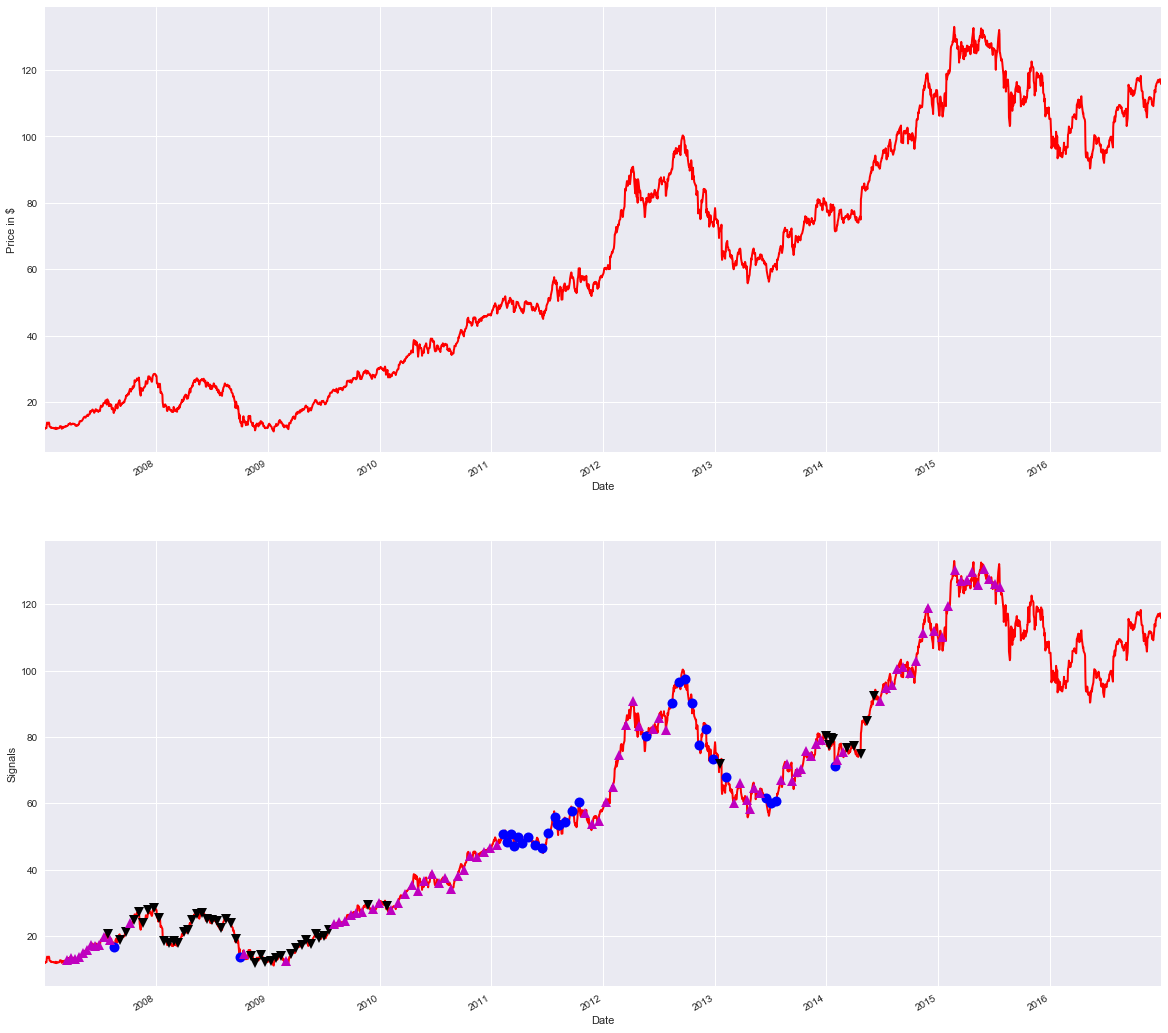

In [14]:
fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(211,  ylabel='Price in $')
ax2 = fig.add_subplot(212,  ylabel='Signals')

# Plot the closing price
env.data['Close'].plot(ax=ax1, color='r', lw=2.)
env.data['Close'].plot(ax=ax2, color='r', lw=2.)

ax2.plot(signals_df.loc[signals_df[1] == 'skip'].index, 
         signals_df.loc[signals_df[1] == 'skip'][2],
         'o', markersize=10, color='b')

ax2.plot(signals_df.loc[signals_df[1] == 'sell'].index, 
         signals_df.loc[signals_df[1] == 'sell'][2],
         'v', markersize=10, color='k')

ax2.plot(signals_df.loc[signals_df[1] == 'buy'].index, 
         signals_df.loc[signals_df[1] == 'buy'][2],
         '^', markersize=10, color='m')
       
# Show the plot
plt.show()

In [15]:
agent.save('best_model.h5')